# CS 328 Final Project
by: Eva Choudhury, Addie Padhi, Alisha Patil

## Imports Section

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import glob


## Preprocessing Data and Filtering 

In [2]:
WINDOW_SIZE = 5  # in seconds
SAMPLE_RATE = 100  # Hz 
SAMPLES_PER_WINDOW = 200

def calc_magnitude(df):
    df['accel_mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df['accel_mag'] -= df['accel_mag'].mean()
    return df

def remove_noise(df, sample_rate=SAMPLE_RATE):
    b, a = butter(N=2, Wn=5/(sample_rate/2), btype='low')
    df['filtered_mag'] = filtfilt(b, a, df['accel_mag'])
    return df

In [3]:
def preprocess_all_files():
    all_windows = []  

    for root, _, files in os.walk("data"):
        for fname in files:
            if not fname.endswith(".csv"):
                continue

            path = os.path.join(root, fname)
            df = pd.read_csv(path)

            df = calc_magnitude(df)
            df = remove_noise(df)

            #plot
            # plt.figure(figsize=(10, 4))
            # plt.plot(df['accel_mag'], label='Raw Magnitude', alpha=0.6)
            # plt.plot(df['filtered_mag'], label='Filtered Magnitude', linewidth=2)
            # plt.title(f"Acceleration Magnitude: {fname}")
            # plt.xlabel("Sample Index")
            # plt.ylabel("Acceleration (m/s²)")
            # plt.legend()
            # plt.tight_layout()
            # plt.show()

            label = os.path.basename(root).lower()
            samples_per_window = 200 

            for start in range(0, len(df) - samples_per_window + 1, samples_per_window):
                window = df.iloc[start:start + samples_per_window].copy()
                window["window_id"] = len(all_windows)
                window["label"] = label
                window["source_file"] = fname
                all_windows.append(window)

    if not all_windows:
        raise ValueError("no data was processed into windows")

    combined_df = pd.concat(all_windows, ignore_index=True)
    return combined_df

combined_df = preprocess_all_files()

# Feature Extraction 

In [4]:
def extract_features_from_windows(df):
    grouped = df.groupby("window_id")
    features = []

    for window_id, window in grouped:
        stats = {
            'window_id': window_id,
            'mean': window['filtered_mag'].mean(),
            'std': window['filtered_mag'].std(),
            'min': window['filtered_mag'].min(),
            'max': window['filtered_mag'].max(),
            'q25': window['filtered_mag'].quantile(0.25),
            'q75': window['filtered_mag'].quantile(0.75),
            'label': window['label'].iloc[0],
            'source_file': window['source_file'].iloc[0]
        }
        features.append(stats)
    
    features_df = pd.DataFrame(features)
    features_df.to_csv("features_for_model.csv", index=False)
    return features_df

# extract features
features_df = extract_features_from_windows(combined_df)
print(features_df)


      window_id      mean       std       min        max       q25       q75  \
0             0  1.290804  2.430083 -4.064783   6.008592 -0.210513  3.308357   
1             1 -1.112792  1.344458 -4.206432   1.009925 -2.254042 -0.087781   
2             2 -0.510144  1.276674 -3.094978   2.186208 -1.513976  0.522823   
3             3 -0.771318  1.482467 -4.078321   2.609255 -1.491498  0.170327   
4             4 -0.601190  1.566836 -3.340550   3.366469 -1.696656  0.368716   
...         ...       ...       ...       ...        ...       ...       ...   
2647       2647 -1.506938  3.127877 -5.291604   6.263867 -4.257684 -0.338925   
2648       2648  0.832963  2.271657 -4.706330   5.766190 -0.407669  2.348943   
2649       2649 -0.706710  4.347161 -6.662409  10.535968 -4.045505  2.708105   
2650       2650  1.511203  3.004178 -5.606460   7.750051 -0.432374  3.688103   
2651       2651 -1.710088  3.520734 -7.136564   6.367229 -4.893950  1.007565   

          label            source_file 

# Modeling and Evaluation

Label counts:
 label
lying         276
walk-fast     275
standing      275
walk-slow     273
downstairs    272
upstairs      271
walk-mod      269
sitting       269
jogging       258
falls         214
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       488
           1       0.81      0.58      0.68        43

    accuracy                           0.95       531
   macro avg       0.89      0.78      0.83       531
weighted avg       0.95      0.95      0.95       531



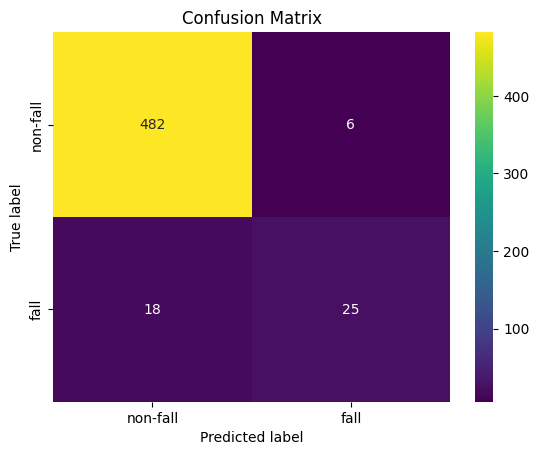

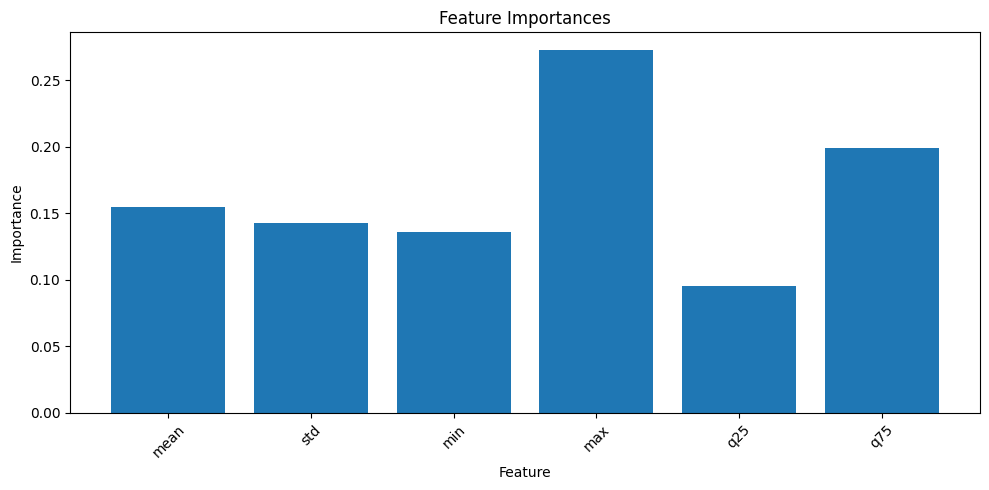

In [5]:
features_df = pd.read_csv("features_for_model.csv")
print("Label counts:\n", features_df["label"].value_counts())

features_df["label"] = features_df["label"].map(lambda x: "fall" if x == "falls" else "non-fall")


features_df = features_df.dropna()

X = features_df.drop(columns=["label", "window_id", "source_file"])
y = features_df["label"].map({'fall': 1, 'non-fall': 0})


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=["non-fall", "fall"],
            yticklabels=["non-fall", "fall"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 5))
plt.bar(feature_names, importances)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
